In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from uncertainties import ufloat, unumpy

In [2]:
m, b = 4.66402766, 2.22976949
m_err, b_err = 0.00618106, 1.384337

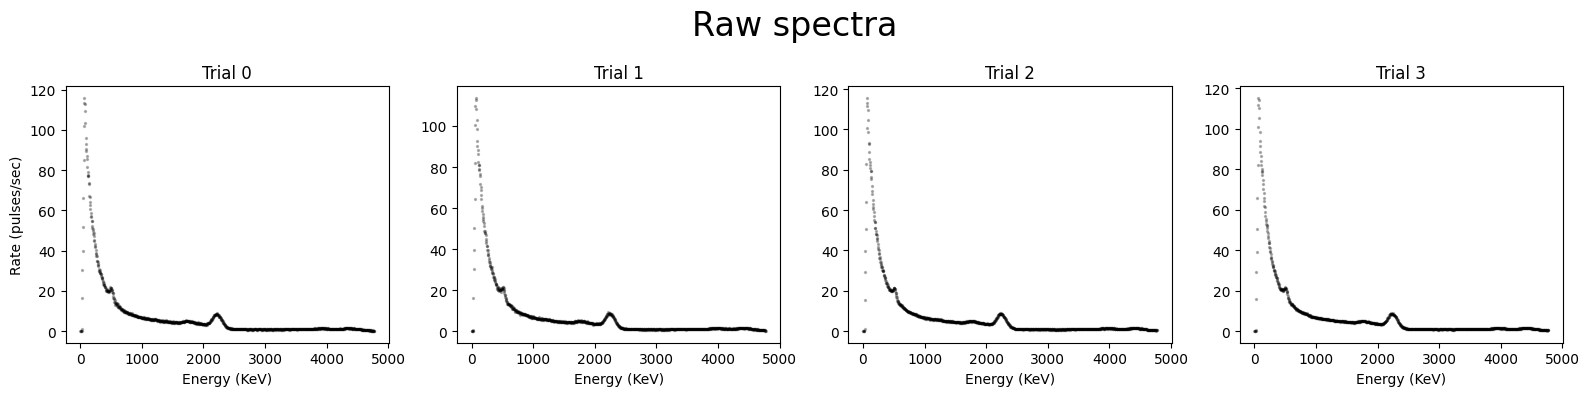

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 4))

for i, ax in enumerate(axs):

    fname = f'./data/pu-plugged-{i}.csv'

    time, channels, counts = parse_usx_csv(fname)
    energy = m * channels + b
    rate = counts / time
    
    ax.scatter(energy, rate, color='k', s=2, alpha=0.25)
    ax.set_title(f'Trial {i}')
    ax.set_xlabel('Energy (KeV)')

axs[0].set_ylabel('Rate (pulses/sec)')
fig.suptitle('Raw spectra', fontsize=24)
plt.tight_layout()

fig.savefig('./figures/gamma_spectra.pdf')

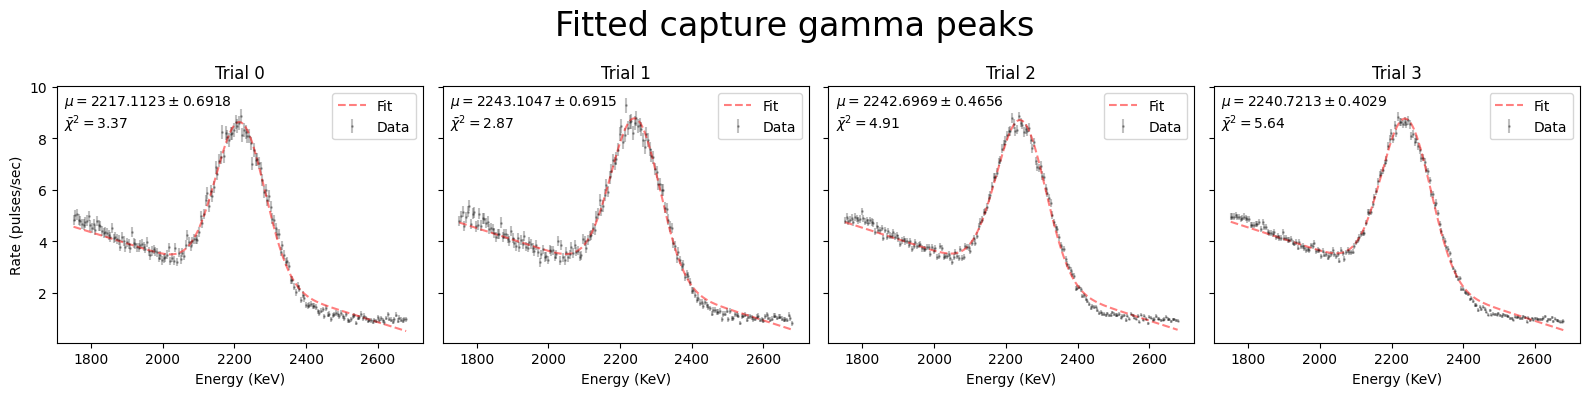

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 4), sharey=True)
x0, x1 = 375, 575

means, means_err = [], []
for i, ax in enumerate(axs):

    fname = f'./data/pu-plugged-{i}.csv'

    time, channels, counts = parse_usx_csv(fname)
    energy = m * channels + b
    rate = counts / time
    rate_err = np.sqrt((counts / time**2) + (counts**2 * 0.1**2 / time**4))

    x, y, y_err = energy[x0:x1], rate[x0:x1], rate_err[x0:x1]
    
    ax.errorbar(
        x, y, yerr=y_err, 
        fmt='k.', markersize=2, alpha=0.25, 
        label='Data'
    )
    ax.set_title(f'Trial {i}')
    ax.set_xlabel('Energy (KeV)')

    params_i = [0, y.min(), (y.max() - y.min()) * x.std(), x[y.argmax()], x.std()/2]
    params, params_err, chisq, dof = data_fit(
        params_i, gaussianlinear, 
        x, y, y_err
    )
    means.append(params[3])
    means_err.append(params_err[3])

    linspace = np.linspace(x.min(), x.max(), num=1000)
    ax.plot(
        linspace, gaussianlinear(params, linspace), 
        color='r', linestyle='dashed', alpha=0.5, 
        label='Fit'
    )

    txt = f'$\mu = {params[3]:.4f} \\pm {params_err[3]:.4f}$ \n'
    txt += '$\\bar{\\chi}^2 = ' + f'{chisq/dof:.2f}$'
    ax.text(0.02, 0.975, txt, transform=ax.transAxes , fontsize=10, va='top')
    ax.legend()

axs[0].set_ylabel('Rate (pulses/sec)')
fig.suptitle('Fitted capture gamma peaks', fontsize=24)
plt.tight_layout()

fig.savefig('./figures/capture_gammas.pdf')

In [5]:
M_p = ufloat(1.67262192595e-27, 0.00000000052e-27)
M_d = ufloat(3.3435837768e-27, 0.000000000010e-27)

umeans = unumpy.uarray(means, means_err)
E_g = umeans.mean() * 1.602176634e-16
g = E_g / (299792458 ** 2)

n = M_d - M_p - g
print(n)

(1.6669760+/-0.0000005)e-27


In [6]:
umeans.mean()

2235.908805373848+/-0.28895421179451053